In [50]:
import torch 
import kaggle 
import os 
import subprocess
from IPython.display import Audio
import pandas as pd 
from matplotlib import pyplot as plt 
import json 
import numpy as np

## Download data from Kaggle
The code will only execute if there is no directory called DATA_PATH.

In [2]:
DATA_PATH = 'birdclef-2022/'

if not os.path.isdir(DATA_PATH):
    import zipfile
    print('downloading birdclef-2022 data from Kaggle')
    subprocess.call(args=['kaggle competitions download -c birdclef-2022'], shell=True)
    os.mkdir(DATA_PATH)
    with zipfile.ZipFile('birdclef-2022.zip', 'r') as f:
        f.extractall(DATA_PATH)

else:
    print('found data')


found data


## Listen to some of the data

In [3]:
with open(f'{DATA_PATH}/scored_birds.json') as f:
    birds = json.load(f)
metadata = pd.read_csv(f'{DATA_PATH}train_metadata.csv')
drop_cols = [ 
    'scientific_name', 
    'common_name', 
    'author', 
    'license', 
    'url'
]

metadata = metadata.drop(drop_cols, axis=1)
print(metadata.head())

  primary_label                secondary_labels                     type  \
0       afrsil1                              []  ['call', 'flight call']   
1       afrsil1  ['houspa', 'redava', 'zebdov']                 ['call']   
2       afrsil1                              []         ['call', 'song']   
3       afrsil1                              []   ['alarm call', 'call']   
4       afrsil1                              []          ['flight call']   

   latitude  longitude  rating   time              filename  
0   12.3910    -1.4930     2.5  08:00  afrsil1/XC125458.ogg  
1   19.8801  -155.7254     3.5  08:30  afrsil1/XC175522.ogg  
2   16.2901   -16.0321     4.0  11:30  afrsil1/XC177993.ogg  
3   17.0922    54.2958     4.0  11:00  afrsil1/XC205893.ogg  
4   21.4581  -157.7252     3.0  16:30  afrsil1/XC207431.ogg  


In [4]:
def get_filename(
        primary_label: str=None, 
        type: str=None, 
        rating_lower: float=None, 
        rating_upper:float=None, 
        metadata: pd.DataFrame=metadata, 
        idx: int=0, 
        data_path=DATA_PATH, 
    ):
    """ 
    find the filename that satisfies the specified criteria
    """
    query = query_metadata(
        primary_label, 
        type, 
        rating_lower, 
        rating_upper, 
        metadata
    )
    filename = f"{data_path}train_audio/{query.loc[idx, 'filename']}"

    return filename 

def query_metadata(
        primary_label: str=None, 
        type: str=None, 
        rating_lower: float=None, 
        rating_upper:float=None, 
        metadata: pd.DataFrame=metadata, 
    ):
    """ 
    Query the metadata based on primary_label, type, and rating (closed interval [rating_lower, rating_upper])
    """
    # criteria for queries:
    true = pd.Series([True]*len(metadata))
    c1 = true if primary_label is None else metadata['primary_label'] == primary_label
    c2 = true if type is None else metadata['type'] == type
    c3 = true if rating_lower is None or rating_upper is None else metadata['rating'].between(rating_lower, rating_upper)

    query = metadata[c1 & c2 & c3].reset_index()
    return query 



In [61]:
# an example query
primary_label = 'afrsil1'
type = "['call']" # saved as a string in the dataframe

# the ratings are float so we specify a closed rating interval
# [rating_lower, rating_upper] from which to take files
rating_lower = 4
rating_upper = rating_lower + .1

filename = get_filename(
        primary_label, 
        type, 
        rating_lower, 
        rating_upper
    )

Audio(filename=filename)

## Class distribution
Check for each bird how often as
- a primary label, 
- a secondary label, 
- or either of the two

Note that there are more birds in the primary label than we are interested in detecting! 

In [22]:
def detect_secondary_occurance(bird, q_list=None, metadata=metadata):
    """ 
    Count the number of times bird occurs as a secondary label 
    """
    if q_list is None:
        import re 
        q_list = list(re.split("[|]|\'", l) for l in metadata['secondary_labels'])
    
    tmp = [int(bird in query) for query in q_list]
    return sum(tmp)

primary = metadata[metadata['primary_label'].isin(birds)].groupby('primary_label').count().iloc[:, 0]

secondary = pd.Series([0]*len(birds), index=birds)

import re
q_list = list(re.split("[|]|\'", l) for l in metadata['secondary_labels'])

for bird in birds:
    secondary[bird] = detect_secondary_occurance(bird, q_list)

either = primary + secondary


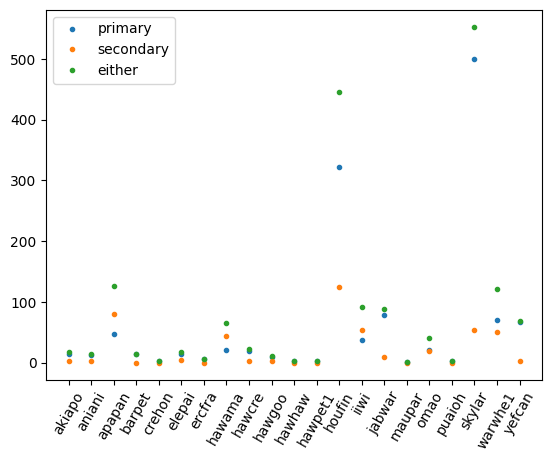

In [58]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# for ax, res, title in zip(axs, [primary, secondary, either], ['primary', 'secondary', 'either']):
#     ax.plot(res, '.')
#     ax.set_title(title)
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60)

# plt.show()
fig, ax = plt.subplots()

ax.plot(primary, '.', label='primary')
ax.plot(secondary, '.', label='secondary')
ax.plot(either, '.', label='either')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60)
ax.legend()
plt.show()
